# Sourcing and Analyzing Time Series Data

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# Import Data

Import IMF cross country macroeconmics 

In [5]:
#configure API Key
quandl.ApiConfig.api_key = 'jny28tVm7TxSzq_ofp4s'

In [6]:
data = quandl.get('ODA/ZWE_NGDPRPPPPC')

In [7]:
data.head(5)

,Value
Date,
1998-12-31,3285.33
1999-12-31,3257.71
2000-12-31,3128.15
2001-12-31,3121.96
2002-12-31,2889.12


In [8]:
#check of rows and columns
data.shape

(27, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

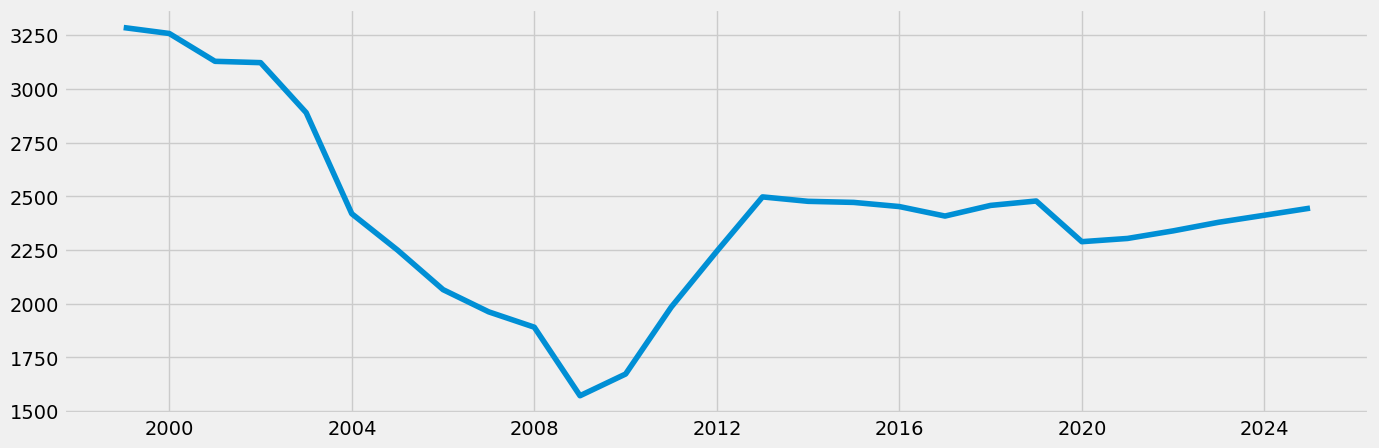

In [10]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

In [11]:
data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1998-12-31,3285.33
1,1999-12-31,3257.71
2,2000-12-31,3128.15
3,2001-12-31,3121.96
4,2002-12-31,2889.12


In [13]:
data_sub = data_2.loc[(data_2['Date'] >='2000-01-01') & (data_2['Date'] < '2023-01-01')]

In [14]:
data_sub.shape

(23, 2)

In [15]:
#Set the date column as index

from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from 'Date'
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column
data_sub.head()

,Value
datetime,
2000-12-31,3128.15
2001-12-31,3121.96
2002-12-31,2889.12
2003-12-31,2418.65
2004-12-31,2249.60


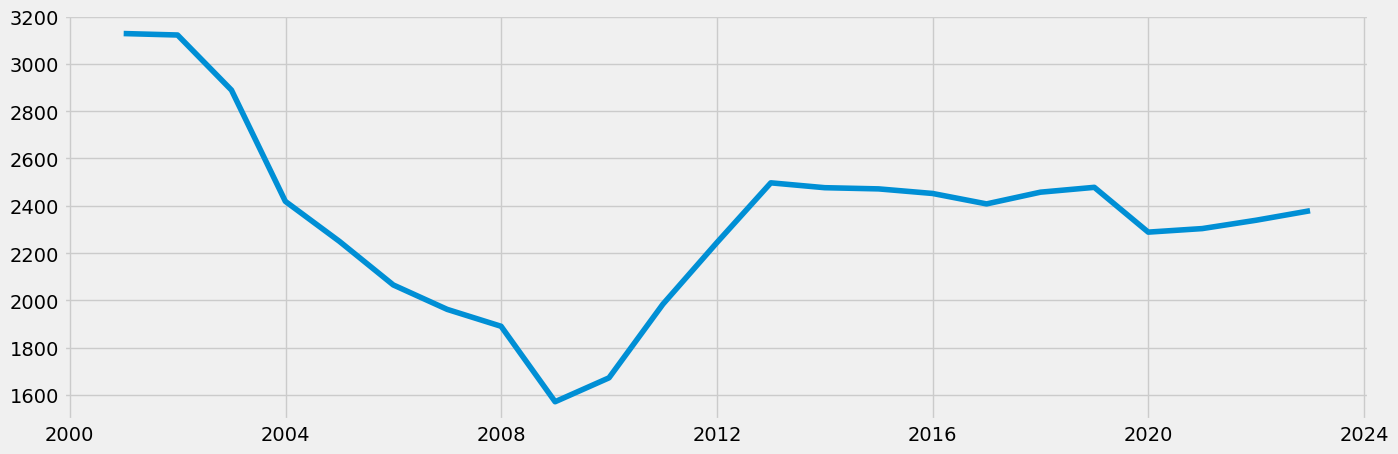

In [16]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
#Check for missing value
data_sub.isnull().sum()

Value    0
dtype: int64

In [18]:
#check for duplicates
dups = data_sub.duplicated()

In [19]:
dups.sum()

0

In [20]:
#from pylab import rcParams # This will define a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7

In [21]:
# 3. Time-series analysis: decomposition"
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

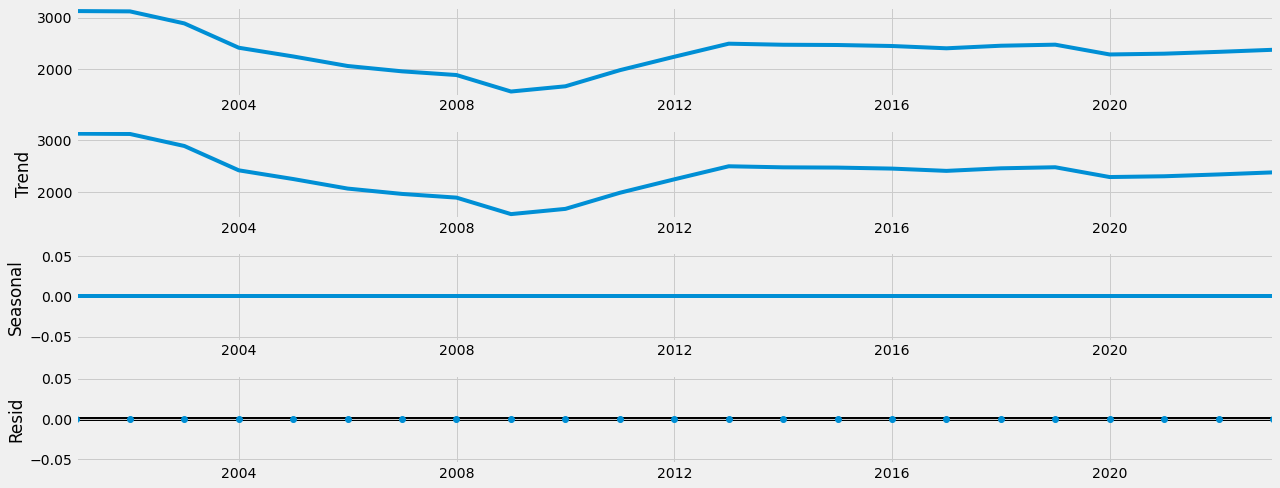

In [22]:
decomposition.plot()
plt.show()

As the level and trend are different, this informs us that the data is unsmoothed. The trend component displays some fluctuations with a steady descrease over the years starting around 2000 with an incline around 2009 which is likely represented by the low commodity price affecting the GDP of the country. The seasonality component displays a flat curve meaning there is no seasonality. The residual shows that there is no unexplained noise. This can be implied that the series is  non stationary.

In [23]:
def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

In [24]:
 dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.399378
p-value                         0.010980
Number of Lags Used             1.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


The test statistic is -3.3 and the p-value is 0.01 which indicates the test result is significant as it is not more than 0.05. Using the critical value (5%) which is -3.01, which is lesser to the test statistic. This means i can
reject the null hypothesis. This indicates that there is a unit root in the data and that the data is stationary

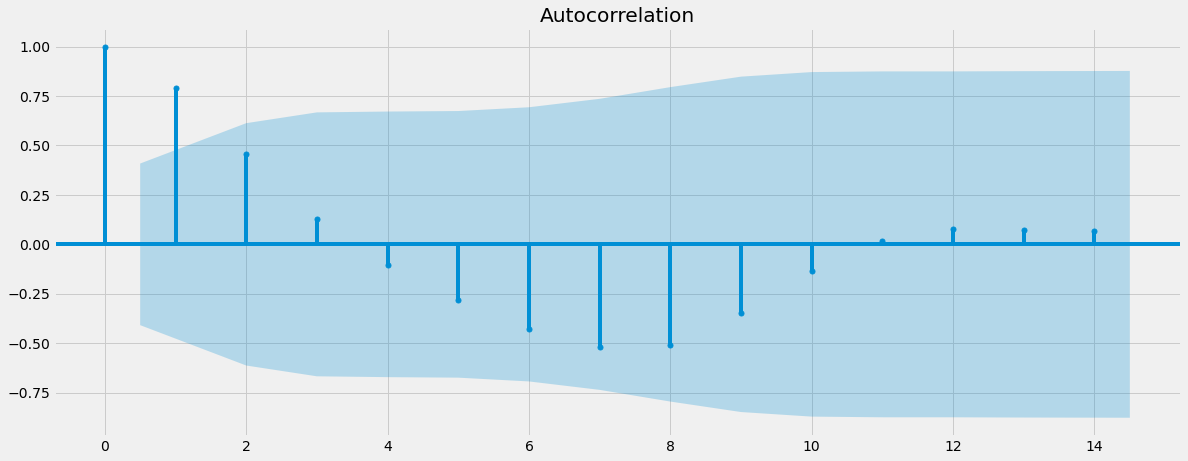

In [25]:
plot_acf(data_sub)
plt.show()

In [26]:
# 5. Stationarizing the IMF cross country Data"
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [27]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing.

In [28]:
data_diff.head()

,Value
datetime,
2001-12-31,-6.19
2002-12-31,-232.84
2003-12-31,-470.47
2004-12-31,-169.05
2005-12-31,-184.38


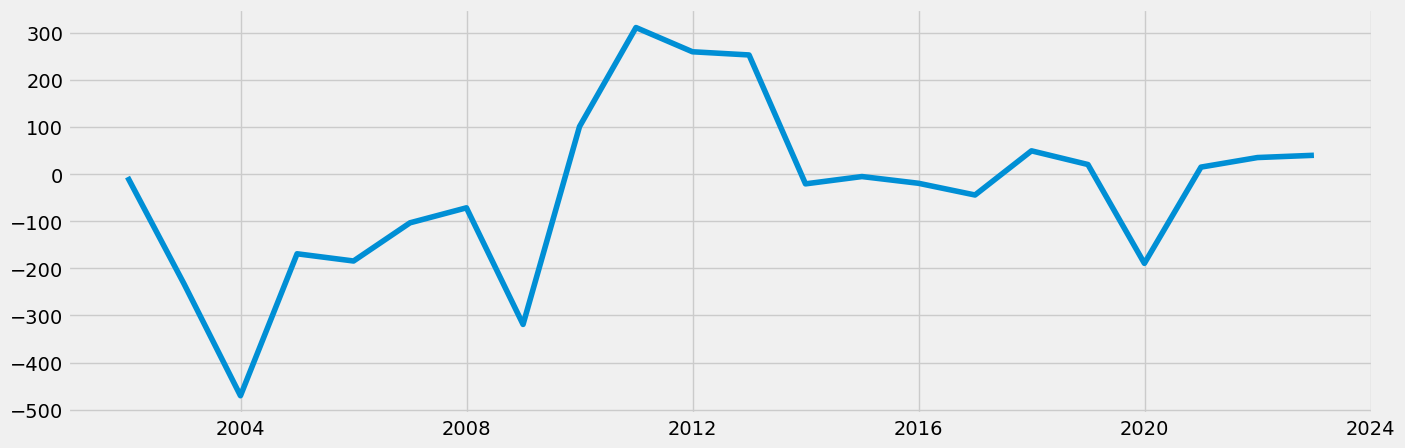

In [29]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.290305
p-value                         0.000006
Number of Lags Used             9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


With differencing, the test-statistic (-5.29) is greater than the critical values at 5% (-3.15) and at 10% (-2.7). The null hypothesis can be rejected and the series is now stationary. The test result is also significant as the p-value is less than 0.05."

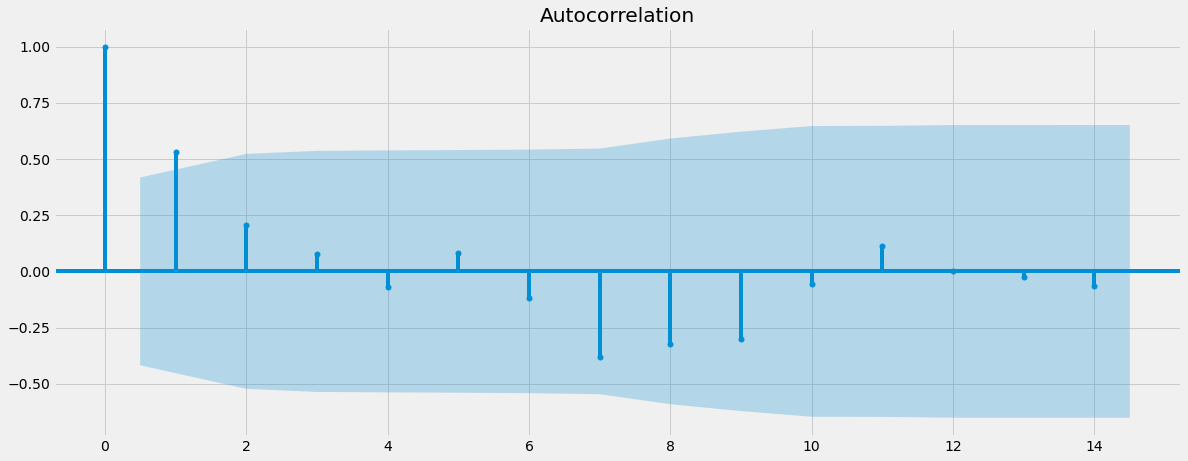

In [32]:
plot_acf(data_diff)
plt.show()

The autocorrelation is significantly different with few autocorrelated terms. However, as there are still lags outside of the confidence interval, it indicates a weak stationarity.